In [87]:
from memo import memo, domain
import jax.numpy as np
import jax
from enum import IntEnum
from matplotlib import pyplot as plt

In [88]:
# Setup
class Role(IntEnum):
    Good = 0
    Evil = 1

class Utterance(IntEnum):
    Accuse = 0
    Defend = 1
    Hedge = 2

class Observation(IntEnum):
    # Observation of mission outcome or perceived statement
    Accused = 0
    Defended = 1
    Neutral = 2

Role = domain(role=2)        # 0 = Good, 1 = Evil
Utterance = domain(u=3)     # 0 = Accuse, 1 = Defend, 2 = Hedge
Observation = domain(o=3)   # 0 = Accused, 1 = Defended, 2 = Neutral


In [89]:
# Likelihood: how utterances map to observations
def run_observation(o, r, u):
    """
    Returns P[o | r, u] using arithmetic expressions (no Python ifs)
    o: 0=Accuse, 1=Defend, 2=Hedge
    r: Role (0=Good, 1=Evil)
    u: Utterance (0=Accuse, 1=Defend, 2=Hedge)
    """
    # Probability of observing Accuse
    p_accuse = 0.1 + 0.7 * r * (u == 0)   # 0.8 if r=1 and u=0, else 0.1
    # Probability of observing Defend
    p_defend = 0.1 + 0.7 * (1 - r) * (u == 1)  # 0.8 if r=0 and u=1, else 0.1
    # Probability of Hedge
    p_hedge = 0.34  # constant

    probs = [p_accuse, p_defend, p_hedge]
    return probs[o]


In [91]:
@memo
def listener[u: Utterance]():
    listener: knows(u)
    listener: chooses(r in Role, wpp=0.5)
    listener: chooses(o in Observation, wpp=run_observation(o, r, u))

    return Pr[listener.r == 1]

In [92]:
@memo
def speaker_uniform[target_r: Role](real_u):
    speaker: knows(target_r)

    # For each utterance, directly assign a softmax probability
    speaker: chooses(u in Utterance, wpp=0.5)  # start uniform

    # Return probability that speaker picks u
    return Pr[speaker.u == real_u]


[0.33333334 0.33333334 0.33333334]


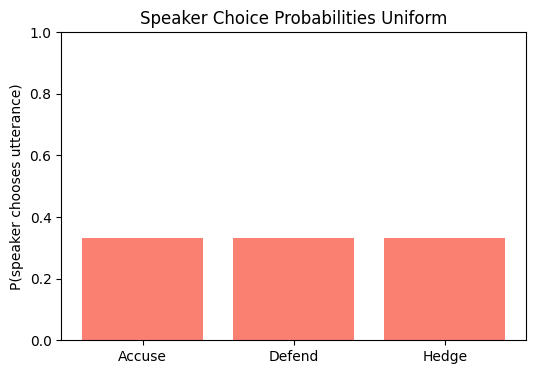

In [93]:
import numpy as np  # regular NumPy for plotting
import matplotlib.pyplot as plt

# Labels
utterance_names = ["Accuse", "Defend", "Hedge"]
role_names = ["Good", "Evil"]

# --- 2. Speaker experiment ---
# For a given target role, compute P[speaker chooses u]

speaker_probs = np.array([np.array(speaker_uniform(u_idx)).item()
                           for u_idx in range(len(utterance_names))])
print(speaker_probs)
# Plot speaker probabilities
plt.figure(figsize=(6, 4))
plt.bar(utterance_names, speaker_probs, color="salmon")
plt.ylim(0, 1)
plt.ylabel("P(speaker chooses utterance)")
plt.title(f"Speaker Choice Probabilities Uniform")
plt.show()


In [95]:
@memo
def speaker_strategic[target_r: Role](real_u):
    speaker: knows(target_r)

    # speaker chooses u in Utterance
    # We encode expected utility as a function of listener's belief
    # listener(u) returns P[target is Evil | utterance u]
    # Memo cannot call listener() inside a list, so we encode as:

    speaker: chooses(
        u in Utterance,
        wpp=exp(
            5.0 * (u == 0) * listener[u]() * (target_r == 1) +   # Accuse favored if target Evil
            5.0 * (u == 1) * (1 - listener[u]()) * (target_r == 0) +  # Defend favored if target Good
            2.0 * (u == 2)                                           # Hedge neutral
        )
    )

    # Return probability of picking the specified utterance
    return Pr[speaker.u == real_u]


In [96]:
import numpy as onp
import matplotlib.pyplot as plt

utterance_names = ["Accuse", "Defend", "Hedge"]
role_names = ["Good", "Evil"]


# --- Speaker experiment ---
speaker_probs = onp.array([float(speaker_strategic(u_idx))
                           for u_idx in range(len(utterance_names))])

print("Speaker probabilities:", speaker_probs)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(utterance_names, speaker_probs, color="salmon")
plt.ylim(0, 1)
plt.ylabel("P(speaker chooses utterance)")
plt.title(f"Speaker Choice Probabilities (Strategic)")
plt.show()


TracerIntegerConversionError: The __index__() method was called on traced array with shape int32[]
The error occurred while tracing the function run_observation at /var/folders/s9/jl22h5wx19501m7p5xz8pr700000gn/T/ipykernel_40517/3467770194.py:2 for jit. This concrete value was not available in Python because it depends on the value of the argument o.
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerIntegerConversionError